## IV Failure Classification with Neural Networks

In [1]:
import os
import sys
sys.path.append('..')
IV_path = os.path.join('..', 'pvops', 'iv')
sys.path.append(IV_path)

from pvops.iv import simulator, extractor, preprocess

### Step 1: Collect your IV curves. 

In this case, we simulate some curves, but you can replace this step by reading in your own data, if wanted.

In [2]:
N_samples = 100

sim = simulator.Simulator(
                pristine_condition = {
                                        'identifier': 'pristine',
                                        'E': 1000,
                                        'Tc': 50,
                                        'Rsh_mult': 1,
                                        'Rs_mult': 1,
                                        'Io_mult': 1,
                                        'Il_mult': 1,
                                        'nnsvth_mult': 1,
                                    },
                replacement_5params = {'I_L_ref': 9.06157444e+00,
                                        'I_o_ref': 1.67727320e-10,
                                        'R_s': 5.35574950e-03,
                                        'R_sh_ref': 3.03330425e+00,
                                        'a_ref': 2.54553421e-02},
                )

#condition = {'identifier':'pristine'}
#sim.add_preset_conditions('complete', condition, save_name = f'Complete_pristine')

condition = {'identifier':'shade','E':600}
sim.add_preset_conditions('complete', condition, save_name = f'Complete_shading')

condition = {'identifier':'verylight_shade',
              'E':975}
sim.add_preset_conditions('complete', condition, save_name = f'Lightshade_pristine')
condition = {'identifier':'cracking',
              'Rs_mult':1.5}
sim.add_preset_conditions('complete', condition, save_name = f'Complete_cracking')

dicts = {'E':       {'mean': 600,
                    'std': 700,
                    'low': 300,
                    'upp': 950,
                    }
        }
sim.generate_many_samples('shade', N_samples, dicts)

dicts = {
        'Rs_mult':{'mean':1.3,
                    'std':0.6,
                    'low':1.1,
                    'upp':1.45
                    }
        }
sim.generate_many_samples('cracking', N_samples, dicts)

sim.build_strings({
                'Pristine array': ['pristine']*12,
                'Partial Soiling (1M)': ['pristine']*11 + ['Complete_shading']*1,
                'Partial Soiling (6M)': ['pristine']*6 + ['Complete_shading']*6,
                'Cell cracking (4M)': ['Lightshade_pristine']*8 + ['Complete_cracking']*4,
                })
sim.simulate()

sim.print_info()

Simulating cells:   0%|          | 0/4 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 4/4 [00:00<00:00, 4010.81it/s]Condition list: (Cell definitions)
	[pristine]: 1 definition(s)
	[shade]: 101 definition(s)
	[verylight_shade]: 1 definition(s)
	[cracking]: 101 definition(s)

Modcell types: (Cell mappings on module)
	[pristine]: 1 definition(s)
	[Complete_shading]: 1 definition(s)
	[Lightshade_pristine]: 1 definition(s)
	[Complete_cracking]: 1 definition(s)

String definitions (Series of modcells)
	[Pristine array]: 1 definition(s)
	[Partial Soiling (1M)]: 101 definition(s)
	[Partial Soiling (6M)]: 101 definition(s)
	[Cell cracking (4M)]: 101 definition(s)




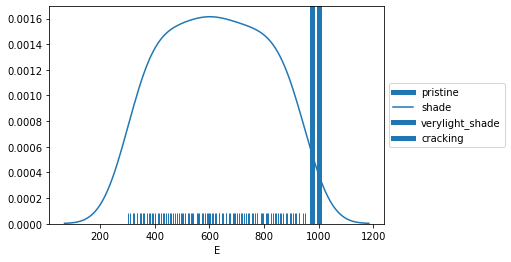

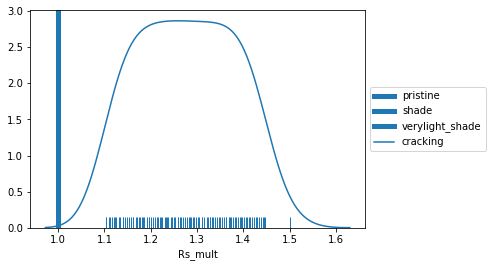

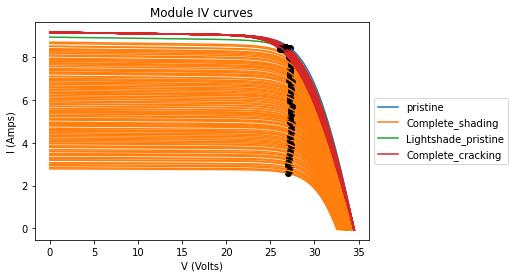

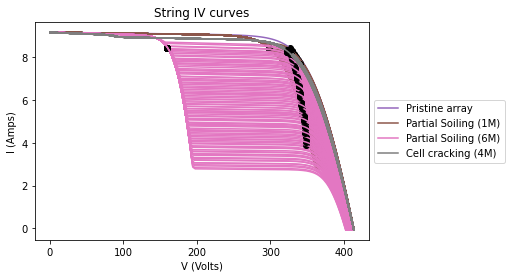

In [3]:
sim.visualize()

In [4]:
df = sim.sims_to_df(focus=['string'], cutoff=True)
df.head()

,current,voltage,E,T,mode,level
0,"[9.169717546586176, 9.164736200080469, 9.15987...","[3.838707129943941e-12, 10.897213632970363, 21...",1000.000000,50.0,Pristine array,string
1,"[9.164736200080469, 9.1598740350008, 9.1551281...","[9.489112496889497, 19.23918367392755, 28.7559...",966.666667,50.0,Partial Soiling (1M),string
2,"[9.164736200080469, 9.1598740350008, 9.1551281...","[9.489112496889497, 19.23918367392755, 28.7559...",969.416567,50.0,Partial Soiling (1M),string
3,"[9.164736200080469, 9.1598740350008, 9.1551281...","[9.489112496889497, 19.23918367392755, 28.7559...",968.574638,50.0,Partial Soiling (1M),string
4,"[9.164736200080469, 9.1598740350008, 9.1551281...","[9.489112496889497, 19.23918367392755, 28.7559...",992.975827,50.0,Partial Soiling (1M),string


In [5]:
labeled = set(df['mode'].tolist())
# df = assets.balance_df(df, 'truncate')
# normalize
prep_df = preprocess.preprocess(df, 0.05, resmpl_cutoff=0.03, correct_gt=False, normalize=True)
# Shuffle
bigdf = prep_df.sample(frac=1).reset_index(drop=True)
bigdf.dropna(inplace=True)
bigdf.head()

,mode,current,voltage,power,E,T
0,Partial Soiling (1M),"[1.0, 0.9988745912091156, 0.9977491353281263, ...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.07990996729672925, 0.1297073875926564...",982.298374,50.0
1,Partial Soiling (1M),"[1.0, 0.9988745616432864, 0.997749076192393, 0...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.0799099649314629, 0.12970737990501108...",982.734902,50.0
2,Cell cracking (4M),"[1.0, 0.996962707198655, 0.9938778792245441, 0...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.0797570165758924, 0.12920412429919073...",983.333333,50.0
3,Partial Soiling (6M),"[1.0, 0.9979461218322789, 0.9958910509790332, ...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.07983568974658231, 0.1294658366272743...",882.435762,50.0
4,Partial Soiling (1M),"[1.0, 0.9988782221268782, 0.9977563976640484, ...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.07991025777015025, 0.1297083316963263...",945.616047,50.0


In [6]:
#from pvops.iv import physics_utils
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def get_diff_array(sample_V, sample_I, pristine_V, pristine_I, debug=False):
    
    if debug:
        plt.plot(sample_V,sample_I,label='sample')
        plt.plot(pristine_V, pristine_I,label='pristine')
        plt.legend()
        plt.grid()
        plt.show()
    
    if sample_V[-1] > pristine_V[-1]:
        if debug:
            print('sample ends in higher V')
        x_smaller = pristine_V
        y_smaller = pristine_I
        x_larger = sample_V
        y_larger = sample_I
        option = 1

    else:
        if debug:
            print('pristine ends in higher V')
        x_smaller = sample_V
        y_smaller = sample_I
        x_larger = pristine_V
        y_larger = pristine_I
        option = 2

    f_interp1 = interp1d(np.flipud(pristine_V), np.flipud(pristine_I),
                        kind='linear', fill_value='extrapolate')
    pristine_I_interp = f_interp1(x_larger)
    pristine_I_interp[pristine_I_interp < 0] = 0

    f_interp2 = interp1d(np.flipud(sample_V), np.flipud(sample_I),
                        kind='linear', fill_value='extrapolate')
    sample_I_interp = f_interp2(sample_V)
    sample_I_interp[sample_I_interp < 0] = 0

    all_V = np.sort(np.unique(np.append(sample_V, pristine_V)))
    all_i1 = f_interp1(all_V)
    all_i1[all_i1 < 0] = 0
    all_i2 = f_interp2(all_V)
    all_i2[all_i2 < 0] = 0
    
    if option == 1:
        diff = all_i2 - all_i1
    if option == 2:
        diff = all_i1 - all_i2
    
    if debug:
        plt.plot(pristine_V,pristine_I,label='prist')
        plt.plot(sample_V,sample_I,label='sample')
        plt.plot(all_V,diff, label='diff')        
        plt.grid()
        plt.legend()
        plt.show()
    
    return all_V, diff

pristine = bigdf[bigdf['mode'] == 'Pristine array']
pristine.sort_values(by=['E','T'], ascending=[False,False],inplace=True)
sub = bigdf[bigdf['mode'] != 'Pristine array']

pristine_V = pristine['voltage'].values[0]
pristine_I = pristine['current'].values[0]

n=0
sample_V = sub['voltage'].values[n]
sample_I = sub['current'].values[n]

diffs = []
for n in range(len(sub)):
    sample_V = sub['voltage'].values[n]
    sample_I = sub['current'].values[n]
    v,i_diff = get_diff_array(sample_V, sample_I, pristine_V, pristine_I)
    diffs.append(i_diff)

sub['diff'] = diffs

ipykernel_launcher:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
bigdf = sub

In [8]:
def feature_generation(df):
    differential = []

    for ind, row in df.iterrows():

        Is2 = row['current']

        differential.append(np.array([0]+[j-i for i, j in zip(Is2[:-1], Is2[1:])]))

    df['differential'] = differential
    return df

bigdf = feature_generation(bigdf)
bigdf.head()

,mode,current,voltage,power,E,T,diff,differential
0,Partial Soiling (1M),"[1.0, 0.9988745912091156, 0.9977491353281263, ...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.07990996729672925, 0.1297073875926564...",982.298374,50.0,"[0.0, 9.289612557383808e-05, 0.000185806039207...","[0.0, -0.001125408790884408, -0.00112545588098..."
1,Partial Soiling (1M),"[1.0, 0.9988745616432864, 0.997749076192393, 0...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.0799099649314629, 0.12970737990501108...",982.734902,50.0,"[0.0, 9.292569140306739e-05, 0.000185865174940...","[0.0, -0.0011254383567136372, -0.0011254854508..."
2,Cell cracking (4M),"[1.0, 0.996962707198655, 0.9938778792245441, 0...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.0797570165758924, 0.12920412429919073...",983.333333,50.0,"[0.0, 0.0020047801360344453, 0.004057062142789...","[0.0, -0.003037292801345015, -0.00308482797411..."
3,Partial Soiling (6M),"[1.0, 0.9979461218322789, 0.9958910509790332, ...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.07983568974658231, 0.1294658366272743...",882.435762,50.0,"[0.0, 0.0010213655024104984, 0.002043890388300...","[0.0, -0.0020538781677210682, -0.0020550708532..."
4,Partial Soiling (1M),"[1.0, 0.9988782221268782, 0.9977563976640484, ...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.03, 0.07991025777015025, 0.1297083316963263...",945.616047,50.0,"[0.0, 8.926520781127323e-05, 0.000178543703285...","[0.0, -0.001121777873121843, -0.00112182446282..."


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin'
import keras
keras.backend.clear_session()
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Flatten, Permute, Activation, RepeatVector, Add
from keras.layers import InputLayer, Input
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, dot, concatenate
from keras.layers import Bidirectional
#from keract import get_activations
from keras.callbacks import Callback
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def convert_ivdata_to_cnn_structure(df, params):
    data = []
    for ind,row in df.iterrows():
        dat = []
        for i in range(len(row[params[0]])):
            da = []
            for param in params:
                da.append(row[param][i])
            dat.append(da)
        data.append(dat)
    return np.asarray(data)

nn_type = 'LSTM_multihead'
params = ['current', 'power', 'differential', 'diff']
num_params = len(params)
max_epochs = 50

y = np.array(bigdf['mode'].tolist())

if nn_type is 'LSTM_multihead':

    def convert_ivdata_to_lstm_multihead_structure(df, params):

        data_features = []
        for param in params:
            data_features.append(bigdf[param].values)

        def list_to_lol(lst,ln):
            # lst: list input
            # len: num vals in each sublist
            maxlen = len(lst)
            i = 0
            l = []
            while i+ln < maxlen:
                x = lst[i:i+ln]
                l.append(x)
                i += ln
            #print(l)
            return l

        n_filters = 10.
        print(f'Making {n_filters} and sample {len(data_features[0][0])}')
        length = int(len(data_features[0][0]) / n_filters) # lists

        restructured_data_features = [[] for _ in range(len(params))]
        for ividx in range(len(data_features[0])):
            for i in range(len(params)):
                restructured_data_features[i].append(list_to_lol(data_features[i][ividx], length))

        for i in range(len(params)):
            restructured_data_features[i] = np.asarray(restructured_data_features[i])
        
        return restructured_data_features

    def grab_structure_lstm_multihead_structure(restructured_data_features, idxs):
        nparms = len(restructured_data_features)
        return [restructured_data_features[i][idxs] for i in range(nparms)]

    X_restructure = convert_ivdata_to_lstm_multihead_structure(bigdf, params)

    c_X = X_restructure[0]

if nn_type is '1DCNN':

    # Below is really all variables, but defining c_X to allow input into rest of code easier
    c_X = convert_ivdata_to_cnn_structure(bigdf, params)

    num_samples_in_IV = len(c_X[0])

Making 10.0 and sample 21


In [14]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
_to_train_encoder = encoder.fit_transform(y)

encoded_length = len(_to_train_encoder[0])

cv = StratifiedKFold(n_splits = 5)
cvscores = []
for train_idx, test_idx in cv.split(c_X, y):
    ytr, yte = y[train_idx], y[test_idx]
    ytr = encoder.transform(ytr)
    yte = encoder.transform(yte)
    encoded_length = len(ytr[0])

    if nn_type is 'LSTM_multihead':

        xtr = grab_structure_lstm_multihead_structure(X_restructure, train_idx)

        n_sequences = np.asarray(xtr).shape[2]
        n_samples_in_sequence = np.asarray(xtr).shape[3]

        xte = grab_structure_lstm_multihead_structure(X_restructure, test_idx)

    elif nn_type is '1DCNN':
        xtr, xte = c_X[train_idx], c_X[test_idx]

    print('xtr shape: ', np.array(xtr).shape)
    print('xte shape: ', np.array(xte).shape)
    print('ytr shape: ', np.array(ytr).shape)
    print('yte shape: ', np.array(yte).shape)

    if nn_type is 'LSTM_multihead':
        units = 50
        dropout_pct = 0.5

        inputs = []
        for i, name in zip(range(num_params), params):
            inputs.append(Input(shape=(n_sequences,n_samples_in_sequence), name=name))

        activations = []
        for i in range(num_params):

            activations.append(LSTM(units, return_sequences = False)(inputs[i]))

        dropouts = []
        for i in range(num_params):
            dropouts.append(Dropout(dropout_pct)(activations[i]))

        pre_mlp = concatenate(dropouts)

        d = Dense(int(((units-encoded_length) / 2) + encoded_length), activation = 'relu', kernel_initializer='normal')(pre_mlp)
        activations = Dense(encoded_length, activation='softmax')(d)
        model = Model(inputs = inputs, outputs = [activations])
        # print(model.summary())

    if nn_type is '1DCNN':
        model = Sequential()
        #filters= 64 -> 256 because experiment369
        print(num_samples_in_IV,num_params)
        model.add(Conv1D(filters=64, kernel_size=12, activation='relu', input_shape=(num_samples_in_IV,num_params)))
        # model.add(Conv1D(filters=64, kernel_size=12, activation='relu'))
        model.add(Dropout(0.5))
        # model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dense(encoded_length, activation='softmax'))

    if True:
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
        import time
        st_time = time.time()
        batchsize = 8
        history = model.fit(xtr, ytr, epochs=max_epochs, batch_size=batchsize, verbose = 0)
        print('FIT TIME: ', time.time() - st_time)
        scores = model.evaluate(xte, yte, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        #print('\tnum.train {} num.test {}'.format(len(xtr), len(xte)))
        cvscores.append(scores[1] * 100)

        
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 50)           0           lstm_2[0][0]                     
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 50)           0           lstm_3[0][0]                     
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 50)           0           lstm_4[0][0]                     
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 200)          0           dropout_1[0][0]                  
                                                                 dropout_2[0][0]                  
                                                                 dropout_3[0][0]                  
 

In [15]:
yhat = model.predict(xtr, batch_size=25, verbose=1)

243/243 [==============================] - 2s 8ms/step


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
#sum(np.argmax(yhat, axis=1) == np.argmax(ytr, axis=1))/ len(yhat)
print(classification_report(np.argmax(ytr, axis=1),np.argmax(yhat, axis=1)))
print(confusion_matrix(np.argmax(ytr, axis=1),np.argmax(yhat, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00        81

    accuracy                           1.00       243
   macro avg       1.00      1.00      1.00       243
weighted avg       1.00      1.00      1.00       243

[[81  0  0]
 [ 0 81  0]
 [ 0  0 81]]


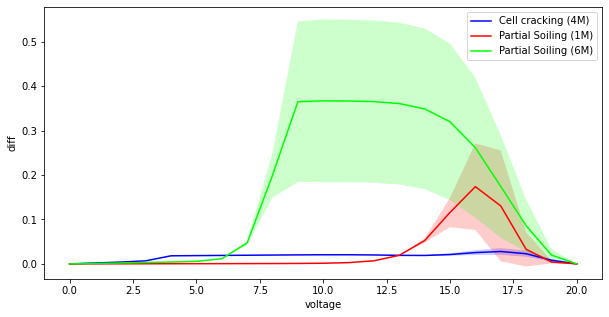

In [74]:
fig = plot_profiles(bigdf, 'voltage', 'diff')
plt.show()